In [1]:

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from scipy.stats import skew
from scipy.stats import kurtosis
slim = tf.contrib.slim





In [2]:
data = pd.read_csv("./../data/credit44_sc.csv" )

In [3]:
# def plot(samples):
#     fig = plt.figure(figsize=(4, 4))
#     gs = gridspec.GridSpec(4, 4)
#     gs.update(wspace=0.05, hspace=0.05)

#     for i, sample in enumerate(samples):
#         ax = plt.subplot(gs[i])
#         plt.axis('off')
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])
#         ax.set_aspect('equal')
#         plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

#     return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


def log(x):
    return tf.log(x + 1e-8)

In [4]:
mb_size = 1000
X_dim = np.shape(data)[1]
z_dim = 20
h_dim = 64
lr = 1e-4
d_steps = 3

n_iter = 5000
n_epoch = 1000
N = n_iter * mb_size  # N data per epoch



mb_size = 32
X_dim = np.shape(data)[1]
z_dim = 64
h_dim = 128
lr = 1e-3
d_steps = 3

나쁘지 않게 나온다.

In [5]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])
z = tf.placeholder(tf.float32, shape=[None, z_dim])
m = tf.placeholder(tf.float32)

# D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
# D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
# D_W2 = tf.Variable(xavier_init([h_dim, 1]))
# D_b2 = tf.Variable(tf.zeros(shape=[1]))

# G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
# G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
# G_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
# G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

# theta_G = [G_W1, G_W2, G_b1, G_b2]
# theta_D = [D_W1, D_W2, D_b1, D_b2]


def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def G(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)
    return G_prob


def D(X):
    D_h1 = tf.nn.relu(tf.matmul(X, D_W1) + D_b1)
    out = tf.matmul(D_h1, D_W2) + D_b2
    return out


def D(X, hsize=None  ,reuse=tf.AUTO_REUSE ):
    with tf.variable_scope( "Discriminator" ,reuse=reuse  ):
        h = tf.layers.dense(X,hsize[0], activation=tf.nn.relu , kernel_initializer= tf.contrib.layers.xavier_initializer() )
        for i in np.arange( len(hsize)-1 )  : 
            h = tf.layers.dense(h,hsize[i+1],activation=tf.nn.relu ,
                                name="total_w_"+str(i), kernel_initializer= tf.contrib.layers.xavier_initializer() )
        X_recon = tf.layers.dense(h,1 ,activation=None ) #  
    return tf.reduce_sum((X - X_recon)**2 , 0) # 1 ?


def G( Z , hsize = None , reuse = tf.AUTO_REUSE) : 
    with tf.variable_scope("Generator" , reuse = reuse) : 
        h = tf.layers.dense(Z,hsize[0], activation=tf.nn.relu , kernel_initializer= tf.contrib.layers.xavier_initializer())
        for i in np.arange( len(hsize)-1 )  : 
            h = tf.layers.dense(h,hsize[i+1],activation=tf.nn.relu ,
                                name="relu_w_"+str(i) , kernel_initializer= tf.contrib.layers.xavier_initializer()) #  , kernel_initializer = tf.variance_scaling_initializer()
        G_prob = tf.layers.dense(h, X_dim , activation=tf.nn.sigmoid )
    return G_prob

In [7]:
hsize =[h_dim] * 3
G_sample = G(z, hsize)

theta_G = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Generator")

theta_D = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Discriminator")

D_real = D(X , hsize)
D_fake = D(G_sample , hsize)


D_recon_loss = tf.reduce_mean(D_real)
D_loss = tf.reduce_mean(D_real + tf.maximum(0., m - D_fake))
G_loss = tf.reduce_mean(D_fake)


D_recon_solver = (tf.train.AdamOptimizer(learning_rate=lr).minimize(D_recon_loss, var_list=theta_D))
D_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(D_loss, var_list=theta_D))
G_solver = (tf.train.AdamOptimizer(learning_rate=lr)
            .minimize(G_loss, var_list=theta_G))

In [8]:
fac_var = []
num_var = []
for i in list(data) : 
    if data[i].nunique() < 15 : 
        print("factor variable : {}, count : {} ".format(i, data[i].nunique()))
        fac_var.append(i)
        if data[i].nunique() == 2 :
            print("binary" , i)
    else : 
        print("연속형 variable : {} , count : {} ".format(i, data[i].nunique()))
        num_var.append(i)
        
data = data.loc[:,fac_var + num_var]

col = list(data)

연속형 variable : SCORE_ORG , count : 395 
연속형 variable : SCORE_NK0200_000 , count : 445 
연속형 variable : SCORE_RK0400_700 , count : 294 
factor variable : CNT_CONTACT_POS, count : 8 
factor variable : CNT_ENG, count : 7 
factor variable : DAYS_CONTACT_POS, count : 11 
factor variable : DAYS_CALL_PAYMENT, count : 11 
factor variable : EWS_C_N_P27000100, count : 14 
연속형 variable : EWS_A_K_D1M232000_OPR , count : 2384 
factor variable : EWS_C_N_P42000200, count : 14 
연속형 variable : EWS_C_N_P32003000 , count : 31 
연속형 variable : AGE , count : 54 
연속형 variable : CNT_Contact , count : 29 
연속형 variable : EWS_A_K_D1M23200C_OPR , count : 2384 
연속형 variable : EWS_C_K_D10310000_OPR , count : 52 
연속형 variable : EWS_A_K_D90232200_OPR , count : 2490 
연속형 variable : D_N_CA0000603 , count : 4894 
연속형 variable : EWS_C_N_P32002600 , count : 22 
연속형 variable : EWS_D_N_P43004000 , count : 399 
factor variable : C_N_PS0001777, count : 11 
factor variable : A_K_D10220000_OPR, count : 9 
연속형 variable : SCORE_RK

In [9]:
from sklearn.preprocessing import MinMaxScaler

def sample_data(data = None , n= len(data)) : 
    output = data[list(np.random.choice(len(data) , n))]
    return output

scaler = MinMaxScaler()

x_plot = pd.DataFrame(sample_data(data = data.values , n=mb_size) , columns = col)
data = scaler.fit_transform(data)

In [10]:
def show_plot( row , ncol ) : 
    
    fig , axes = plt.subplots(row , ncol , figsize = (26,13))
    fig.subplots_adjust(hspace = 0.2 , wspace= 0.14 , top = 0.92 , left = 0.03 , bottom = 0.04 , right = 0.99)
    total = sess.run(G_sample, feed_dict={z: sample_z(mb_size, z_dim)})
    try : 
        total = total[~np.isnan(total).any(axis=1)]
        total = scaler.inverse_transform(total)
        g_plot = pd.DataFrame(total , columns = col )
        g_plot[fac_var] = g_plot[fac_var].round(0)
        """
        좀 더 쉬운 분포로 만들어서 학습시킨 후 다시 원래값으로 (factor 변수이기 때문에 가능하다 생각함.)
        """
        #g_plot['DAYS_CONTACT_POS'].replace(to_replace=[1.0], value=7777.0, inplace=True)
        #g_plot['DAYS_CONTACT_POS'].mask(g_plot['DAYS_CONTACT_POS'] > 0.5 , 7777.0, inplace=True)
        #g_plot['DAYS_CALL_PAYMENT'].replace(to_replace=[1.0], value=7777.0, inplace=True)
        STAT4 = pd.read_csv("./describe.csv")
        SKEW = pd.DataFrame(g_plot.skew() , columns = ["skew"]).T
        KURT = pd.DataFrame(g_plot.kurt() , columns = ["kurt"]).T
        STAT2 = pd.concat([SKEW , KURT])
        STAT3 =pd.concat([g_plot.describe(), STAT2])
        stat4 = pd.concat([STAT4 , STAT3])
        # .rename( [STAT3.index.tolist()*2] )
        stat4.index = STAT3.index.tolist()*2
        stat4.to_csv("./real_fake_describe.csv")
        print("통계량 값 저장")
        
        col2 = 0

        for j in range(row) :
            for k in range(ncol) :
                try :
                    label = col[col2]
                    sample = g_plot.loc[: , label]
                    sample.name = "Gene"
                    real_0 = x_plot.loc[: , label]
                    real_0.name ="Real"
                    col2 += 1
                    if label in fac_var : 
                        sns.distplot( sample , ax=axes[j , k], norm_hist =True , kde=False , hist_kws ={"color":"r" , "label" :"Gene", "rwidth":0.75})
                        sns.distplot(real_0 , ax=axes[j , k],norm_hist =True, kde=False , hist_kws ={"color":"g" , "label" :"Real", "rwidth":0.75})
                        axes[j , k].legend(fontsize = 10)
                    elif label in num_var : 
                        sns.distplot(  sample , ax=axes[j , k] ,
                                     kde_kws={"color": "r", "lw": 2, "label": "Gene" , "shade" : True} , hist =False , rug = False) #   
                        sns.distplot(  real_0 , ax=axes[j , k] ,
                                     kde_kws={"color": "g", "lw": 2, "label": "Real", "shade" : True } , hist =False , rug = False) # 
                        axes[j , k].legend(fontsize = 10 )
                    axes[j , k].set_title( label , loc ="left" , fontsize= 10 )
                except IndexError as e : 
                    axes[j , k].axis("off")

        plt.suptitle('Magan Iteration {} , Name : {} , margin : {} , L : {}'.format(i,res ,  margin, L) , fontsize= 30)
        plt.savefig("./visualization_MaGan.png")
        plt.show()
        

        fig , ax = plt.subplots(figsize = (26,13))
        fig.subplots_adjust(top = 0.95 , left = 0.03 , bottom = 0.04 , right = 0.99)

        ax.plot(output.iter , output.margin , label ="margin" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.plot(output.iter , output.Converge_Measure , label ="L" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.stat , label ="stat" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.dfac , label ="D_FAC" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.dnum , label ="D_NUM" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
#         ax.plot(output.iter , output.dtotal , label ="D_TOTAL" , linestyle ="-" , marker ="." , linewidth = 4, markersize = 12)
        ax.set_title("Iter : {} , Name : {} , margin : {} , L : {}".format(iteration-1 ,  res , margin, L), fontsize= 30)
        ax.set_ylim(-5, 15)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4 , fontsize= 20)
        plt.savefig("./iteration_loss_log_MaGan.png")
        plt.show()
        
    except Exception as e : 
        print(e)


Iter: 990; margin: 842.6672973632812; Converge: 7.723792141210938
통계량 값 저장


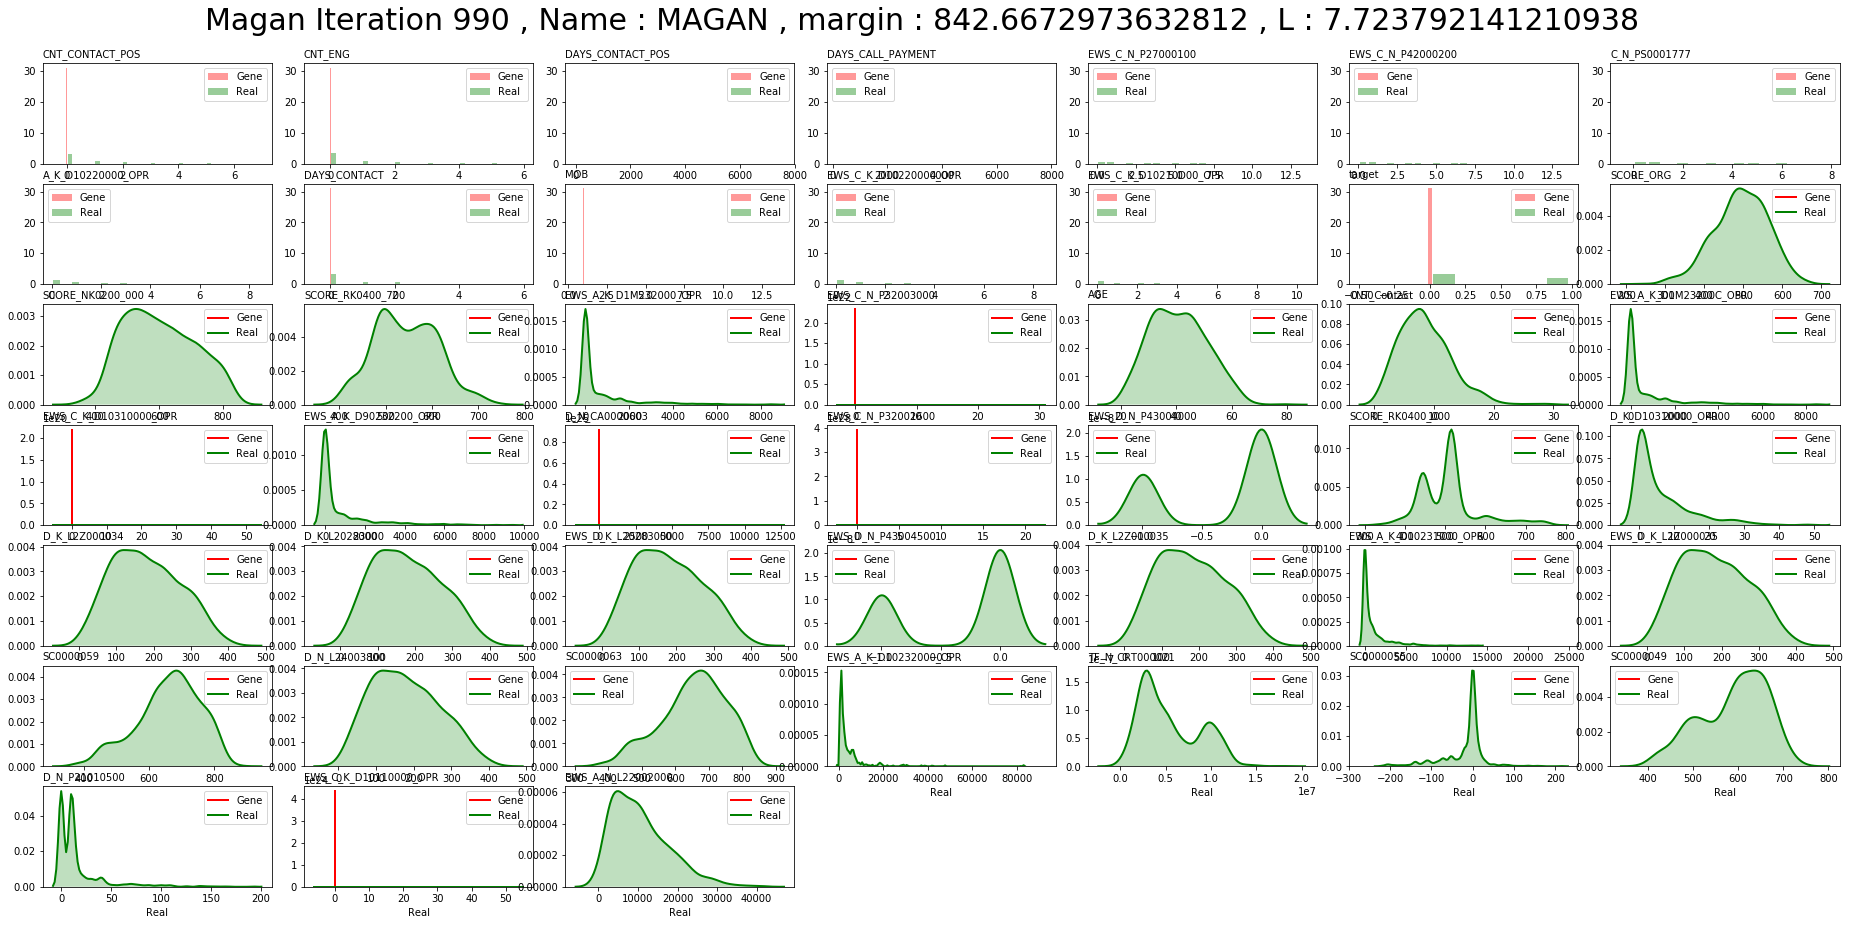

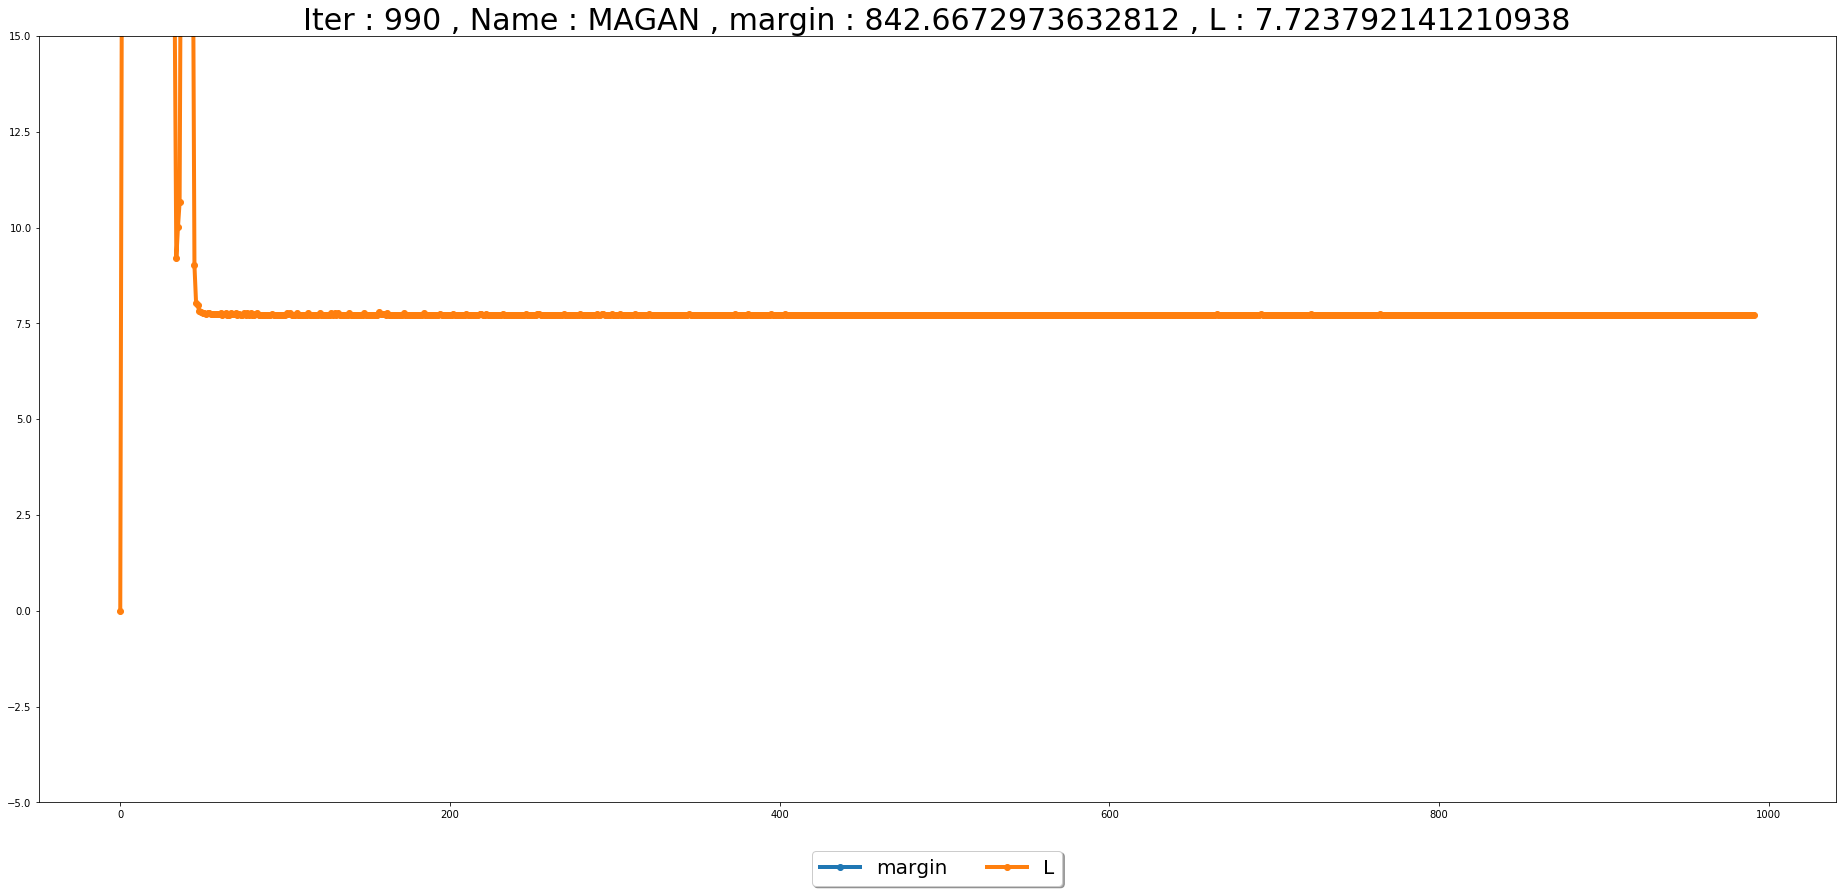

In [11]:
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pretrain
for it in range(2*n_iter):
    X_mb = sample_data(data = data , n=mb_size)

    _, D_recon_loss_curr = sess.run([D_recon_solver, D_recon_loss], 
                                    feed_dict={X: X_mb})

    if it % 1000 == 0:
        print('Iter-{}; Pretrained D loss: {:.4}'.format(it, D_recon_loss_curr))



# Initial margin, expected energy of real data

margin = sess.run(D_recon_loss, feed_dict={X: data})
s_z_before = np.inf     
        
iteration ,  L =  0, 0
output = pd.DataFrame({"iter" : [iteration] , "margin" : [margin] , "Converge_Measure" : [L] })

for i in range(n_epoch):
    s_x, s_z = 0., 0.
    for it in range(n_iter):
        X_mb = sample_data(data = data , n=mb_size)
        z_mb = sample_z(mb_size, z_dim)

        _, D_loss_curr, D_real_curr = sess.run(
            [D_solver, D_loss, D_real], feed_dict={X: X_mb, z: z_mb, m: margin})

        # Update real samples statistics
        s_x += np.sum(D_real_curr)

        _, G_loss_curr, D_fake_curr = sess.run(
            [G_solver, G_loss, D_fake],
            feed_dict={X: X_mb, z: sample_z(mb_size, z_dim), m: margin}
        )
    # Update margin
    if (s_x / N < margin) and (s_x < s_z) and (s_z_before < s_z):
        margin = s_x / N
    
    s_z_before = s_z
    Ex = s_x / N
    Ez = s_z / N
    L = Ex + np.abs(Ex - Ez)
    
    iteration +=1
    
        
    output1 = pd.DataFrame({"iter" : [iteration] , "margin" : [margin] , "Converge_Measure" : [L] })
    output  = output.append(output1)
    if i % 10 == 0:
        clear_output(wait= True)
        print('Iter: {}; margin: {}; Converge: {}'.format(i, margin, L))
        res ="MAGAN"
        show_plot( row = 7 , ncol=7)